# Train a machine learning model with Spark MLlib

Spark MLlib enables you to train, validate, and use machine learning models on Apache Spark.

In this notebook, you'll implement a machine learning solution that predicts whether or not a flight will arrive late based on a number of factors, such as the day and time of the flight, the origin and destination airports, the carrier operating the flight, and any departure delays.

> **Note**: This noteook is designed to be run in an Azure Synapse Analytics Spark pool.


## Attach this notebook to a Spark pool

To run the code in this notebook, you'll need to use a Spark pool; so at the top of this notebook, in the **Attach to** list, select your Spark pool.

## Load data into the default storage account linked to Synapse

## Explore Data

Before training a model, a data scientists generally explores the data with which the model will be trained, and prepares it by removing errors and outliers, identifying predictive features, and potentially using *feature engineering* techniques to augment the data with new derived values that will result in a more predictive model.

In this example, you'll explore some historical flight data with which we'll later train a model to predict whether or not a flight will arrive late. Along the way, we'll encounter somecommon techniques used to load and explore data in Spark.


### Load Data Using an Explicit Schema

Let's start by loading some historical flight data into a dataframe. If the structure of the data is known ahead of time, you can explicitly specify the schema for the dataframe.

Review the code in the cell below, which defines a schema for flight data before loading it from a text file. Then click the **&#9655;** button to the left of the cell to run it.

> **Note**: The first time you run a cell in a notebook, the Spark pool must be started; which can take a few minutes.

In [7]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd

flightSchema = StructType([
  StructField("DayofMonth", IntegerType(), False),
  StructField("DayOfWeek", IntegerType(), False),
  StructField("Carrier", StringType(), False),
  StructField("OriginAirportID", IntegerType(), False),
  StructField("DestAirportID", IntegerType(), False),
  StructField("DepDelay", IntegerType(), False),
  StructField("ArrDelay", IntegerType(), False),
])

# Provided by Spark SQL to read a csv file into a Spark DataFrame
flights=spark.read.csv('abfss://data@datalakeezi1n72.dfs.core.windows.net/raw-flight-data.csv',
                        schema=flightSchema, header=True)
display(flights.limit(5))

StatementMeta(sparkezi1n72, 35, 7, Finished, Available)

SynapseWidget(Synapse.DataFrame, 24f414be-e9f5-4665-b362-36c82a4d54c1)

### Infer a Data Schema
If the structure of the data source is unknown, you can have Spark automatically infer the schema.

In this case, you will load data about airports without knowing the schema.

Run the following cell to load airport data from a text file, inferring the column names and data types automatically.

In [8]:
airports = spark.read.csv('abfss://data@datalakeezi1n72.dfs.core.windows.net/airports.csv', header=True)
display(airports.limit(5))

StatementMeta(sparkezi1n72, 35, 8, Finished, Available)

SynapseWidget(Synapse.DataFrame, 17829497-e801-4ae0-9456-8d35d5e7cac4)

In [9]:
# Get df schema
airports.printSchema()

StatementMeta(sparkezi1n72, 35, 9, Finished, Available)

root
 |-- airport_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- name: string (nullable = true)



### Use Dataframe Methods
Spark DataFrames provide functions that you can use to extract and manipulate data. For example, you can use the **select** function to return a new dataframe containing columns selected from an existing dataframe.

In [11]:
cities = airports.select("city", "name")
display(cities.limit(5))

StatementMeta(sparkezi1n72, 35, 11, Finished, Available)

SynapseWidget(Synapse.DataFrame, 95e5af37-7f9f-4dfa-9418-2debd9ae27e9)

### Combine Operations
You can combine functions in a single statement to perform multiple operations on a dataframe. In this case, you will use the **join** function to combine the **flights** and **airports** dataframes, and then use the **groupBy** and **count** functions to return the number of flights from each airport, and finally use the **orderBy** function to sort the results by the number of flights.

In [12]:
flightsByOrigin = flights.join(airports, flights.OriginAirportID == airports.airport_id).groupBy("city").count().orderBy("count")
display(flightsByOrigin.limit(5))

StatementMeta(sparkezi1n72, 35, 12, Finished, Available)

SynapseWidget(Synapse.DataFrame, df26588c-2c51-4009-b3f7-2437aa09b3de)

### Count the Rows in a Dataframe
Now that you're familiar with working with dataframes, a key task when building predictive solutions is to explore the data, determing statistics that will help you understand the data before building predictive models. For example, how many rows of flight data do you actually have?

In [13]:
flights.count()

StatementMeta(sparkezi1n72, 35, 13, Finished, Available)

2719418

### Determine the Presence of Duplicates
The data you have to work with won't always be perfect - often you'll want to *clean* the data; for example to detect and remove duplicates that might affect your model. You can use the **dropDuplicates** function to create a new dataframe with the duplicates removed, enabling you to determine how many rows are duplicates of other rows.

In [14]:
flights.count() - flights.dropDuplicates().count()

StatementMeta(sparkezi1n72, 35, 14, Finished, Available)

22435

### Identify Missing Values
As well as determining if duplicates exist in your data, you should detect missing values, and either remove rows containing missing data or replace the missing values with a suitable relacement. The **dropna** function creates a dataframe with any rows containing missing data removed - you can specify a subset of columns, and whether the row should be removed in *any* or *all* values are missing. You can then use this new dataframe to determine how many rows contain missing values.

In [15]:
flights.count() - flights.dropDuplicates().dropna(how="any", subset=["ArrDelay", "DepDelay"]).count()

StatementMeta(sparkezi1n72, 35, 15, Finished, Available)

46233

### Clean the Data
Now that you've identified that there are duplicates and missing values, you can clean the data by removing the duplicates and replacing the missing values. The **fillna** function replaces missing values with a specified replacement value. In this case, you'll remove all duplicate rows and replace missing **ArrDelay** and **DepDelay** values with **0**.

In [16]:
data=flights.dropDuplicates().fillna(value=0, subset=["ArrDelay", "DepDelay"])
data.count()

StatementMeta(sparkezi1n72, 35, 16, Finished, Available)

2696983

### Explore the Data
Now that you've cleaned the data, you can start to explore it and perform some basic analysis. Let's start by examining the lateness of a flight. The dataset includes the **ArrDelay** field, which tells you how many minutes behind schedule a flight arrived. However, if a flight is only a few minutes behind schedule, you might not consider it *late*. Let's make our definition of lateness such that flights that arrive within 25 minutes of their scheduled arrival time are considered on-time, but any flights that are more than 25 minutes behind schedule are classified as *late*. We'll add a column to indicate this classification:

In [17]:
data = data.select("DayofMonth", "DayOfWeek", "Carrier", "OriginAirportID","DestAirportID",
                   "DepDelay", "ArrDelay", ((col("ArrDelay") > 25).cast("Int").alias("Late")))
display(data.limit(5))

StatementMeta(sparkezi1n72, 35, 17, Finished, Available)

SynapseWidget(Synapse.DataFrame, 82178e40-dd8f-4501-896a-0201d60a5f43)

### Explore Summary Statistics and Data Distribution
Predictive modeling is based on statistics and probability, so we should take a look at the summary statistics for the columns in our data. The **describe** function returns a dataframe containing the **count**, **mean**, **standard deviation**, **minimum**, and **maximum** values for each numeric column.

In [18]:
display(data.describe())

StatementMeta(sparkezi1n72, 35, 18, Finished, Available)

SynapseWidget(Synapse.DataFrame, afbbe480-0717-4881-98de-8af315f56df4)

The *DayofMonth* is a value between 1 and 31, and the mean is around halfway between these values; which seems about right. The same is true for the *DayofWeek* which is a value between 1 and 7. *Carrier* is a string, so there are no numeric statistics; and we can ignore the statistics for the airport IDs - they're just unique identifiers for the airports, not actually numeric values. The departure and arrival delays range between 63 or 94 minutes ahead of schedule, and over 1,800 minutes behind schedule. The means are much closer to zero than this, and the standard deviation is quite large; so there's quite a bit of variance in the delays. The *Late* indicator is a 1 or a 0, but the mean is very close to 0; which implies that there significantly fewer late flights than non-late flights.

Let's verify that assumption by creating a table and using the **Spark SQL** API to run a SQL statement that counts the number of late and non-late flights:

In [19]:
data.createOrReplaceTempView("flightData")
lateCounts = spark.sql("SELECT COUNT(*) AS Count, Late FROM flightData GROUP BY Late")
display(lateCounts)

StatementMeta(sparkezi1n72, 35, 19, Finished, Available)

SynapseWidget(Synapse.DataFrame, 3631dd43-4da1-4283-8db9-59c2b968506b)

Yes, it looks like there are significantly more non-late flights than late ones. You can see this more clearly with a visualization, so in the output above, select the **Chart** view to see the comparative counts as a bar chart..

Let's address the outliers and imbalanced classes in our data by removing rows with extreme delay values, and *undersampling* the more common on-time flights:

In [20]:
from pyspark.sql.functions import rand

# Remove outliers - let's make the cut-off 150 minutes.
data = data.filter("DepDelay < 150 AND ArrDelay < 150")

# Separate the late and on-time flights
pos = data.filter("Late = 1")
neg = data.filter("Late = 0")

# undersample the most prevalent class to get a roughly even distribution
posCount = pos.count()
negCount = neg.count()
if posCount > negCount:
  pos = pos.sample(True, negCount/(negCount + posCount))
else:
  neg = neg.sample(True, posCount/(negCount + posCount))
  
# shuffle into random order (so a sample of the first 1000 has a mix of classes)
data = neg.union(pos).orderBy(rand())

# Replace the temporary table so we can query and visualize the balanced dataset
data.createOrReplaceTempView("flightData")

# Show the statistics
display(data.describe())

StatementMeta(sparkezi1n72, 35, 20, Finished, Available)

SynapseWidget(Synapse.DataFrame, 0bffaf8c-e9e4-44f9-8d38-cfdd68d72068)

Now the maximums for the **DepDelay** and **ArrDelay** are clipped at under 150, and the mean value for the binary *Late* class is nearer 0.5; indicating a more or less even number of each class. We removed some data to accomplish this balancing act, but there are still a substantial number of rows for us to train a machine learning model with, and now the data is more balanced. Let's visualize the data again to confirm this:

In [21]:
%%sql
SELECT Late, COUNT(*) AS Count FROM flightData GROUP BY Late

StatementMeta(sparkezi1n72, 35, 21, Finished, Available)

<Spark SQL result set with 2 rows and 2 fields>

Display the data as a chart to compare the distribution of the **Late** classes as you did previously. There should now be a more even number of each class.

### Explore Relationships in the Data
Predictive modeling is largely based on statistical relationships between fields in the data. To design a good model, you need to understand how the data points relate to one another.

A common way to start exploring relationships is to create visualizations that compare two or more data values. For example, run the following query to compare arrival delay by carrier.


In [22]:
%%sql
SELECT Carrier, ArrDelay FROM flightData

StatementMeta(sparkezi1n72, 35, 22, Finished, Available)

<Spark SQL result set with 1000 rows and 2 fields>

View the output as a chart, and then use the **View Options** button (which looks similar to **&#128463;<sub>*</sub>**) at the top-right of the output to configure the chart as follows:

- **Chart type**: Box plot
- **Key**: Carrier
- **Values**: ArrDelay

When you apply the view options, the box plots should should show that the median delay (the line in the middle of the box), and the distribution of delays varies by carrier; with some carriers having a higher median delay than others. The same is true for other features, such as the day of the week and the destination airport.



You may already suspect that there's likely to be a relationship between departure delay and arrival delay, so let's examine that next. Run the next cell to retrieve the departure and arrival delays for each flight.

In [23]:
%%sql
SELECT DepDelay, ArrDelay FROM flightData

StatementMeta(sparkezi1n72, 35, 23, Finished, Available)

<Spark SQL result set with 1000 rows and 2 fields>

View the utput as a chart, and set the view options as follows:

- **Chart type**: Scatter chart
- **Key**: DepDelay
- **Values**: ArrDelay
- **Series Group**: *blank*
- **Aggregation**: Avg

The scatter plot shows the average arrival deplay for each recorded departure delay. Note that the points form a diagonal line, which indicates a strong linear relationship between departure delay and arrival delay.

This linear relationship shows a *correlation* between these two values, which we can measure statistically. The **corr** function calculates a correlation value between -1 and 1, indicating the strength of correlation between two fields. A strong positive correlation (near 1) indicates that high values for one column are often found with high values for the other, which a strong negative correlation (near -1) indicates that *low* values for one column are often found with *high* values for the other. A correlation near 0 indicates little apparent relationship between the fields.

Run the following cell to see the correlation statistic for these two variables.

In [24]:
data.corr("DepDelay", "ArrDelay")

StatementMeta(sparkezi1n72, 35, 24, Finished, Available)

0.8970100122207615

The correlation is close to 1, indicating a reasonably strong positive correlation between departure delay and arrval delay. Flights that depart late, unsurprisingly, often arrive late!

## Train a machine learning model

In a real scenario, a data scientist would explore the statistical distributions and relationships in the data in more depth, and perform *feature engineering* to prepare the dataset for training a machine learning model. In this exercise, we've provided a prepared version of the data for you. Use the following code to load it into a dataframe.

In [29]:
flightSchema = StructType([
  StructField("DayofMonth", IntegerType(), False),
  StructField("DayOfWeek", IntegerType(), False),
  StructField("Carrier", StringType(), False),
  StructField("OriginAirportID", IntegerType(), False),
  StructField("DestAirportID", IntegerType(), False),
  StructField("DepDelay", IntegerType(), False),
  StructField("ArrDelay", IntegerType(), False),
  StructField("Late", IntegerType(), False),
])


data = spark.read.csv('abfss://data@datalakeezi1n72.dfs.core.windows.net/flights.csv', schema=flightSchema, header=True)

display(data.limit(5))

StatementMeta(sparkezi1n72, 35, 29, Finished, Available)

SynapseWidget(Synapse.DataFrame, 16dcf856-937b-44cb-bdcf-3a9ce29eaa87)

### Split the training data

It is common practice when building supervised machine learning models to split the source data, using some of it to train the model and reserving some to test the trained model. In this exercise, you will use 70% of the data for training, and reserve 30% for testing.

In [30]:
splits = data.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1]
train_rows = train.count()
test_rows = test.count()
print ("Training Rows:", train_rows, " Testing Rows:", test_rows)

StatementMeta(sparkezi1n72, 35, 30, Finished, Available)

Training Rows: 446310  Testing Rows: 190773


### Define a model training pipeline

A machine learning model is created by fitiing the training data to an algorithm that uses the input *features* to calculate a probably value for a predicted *label*. There are lots of available algorithms for specific kinds of machine learning model. or example, *classification* algorithms like *logistic regression* use features as inputs to calculate a probably *class* (or categorization); while *regression* algorithms, like *linear regression*, can be used to predict a numeric value. In this case, we're trying to predict whether a flight is going to be late or not, so this is an example of a *classification* problem. Specifically, since it requires a prediction based on two possible classes (essentially, *true* or *false*), it's an example of *binary classification*.

However, while you can train a model by fitting your raw data to an algorithm, a good model often requires multiple stages of feature preparation. For example, it is common when using some algorithms to distingish between continuous features (which have a calculable numeric value) and categorical features (which are numeric representations of discrete categories). It is also common to *normalize* continuous numeric features to use a common scale - for example, by scaling all numbers to a proportional decimal value between 0 and 1 (strictly speaking, it only really makes sense to do this when you have multiple numeric columns - normalizing them all to similar scales prevents a feature with particularly large values from dominating the training of the model - in this case, we only have one non-categorical numeric feature; but we've included this so you can see how it's done!).

A pipeline consists of a series of *transformer* and *estimator* components that typically prepare a dataframe for
modeling and then train a predictive model. In this case, you will create a pipeline with the following components:
- A **StringIndexer** estimator for each categorical variable to generate numeric indexes for categorical features
- A **VectorAssembler** that creates a vector of continuous numeric features
- A **MinMaxScaler** that normalizes vector of numeric features
- A **VectorAssembler** that creates a vector of categorical and continuous features
- A **LogisticRegression** algorithm that trains a classification model.


In [31]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler

# convert monthdays to indexed categories
monthdayIndexer = StringIndexer(inputCol="DayofMonth", outputCol="DayofMonthIdx")
# convert weekdays to indexed categories
weekdayIndexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeekIdx")
# convert carriers to indexed categories
carrierIndexer = StringIndexer(inputCol="Carrier", outputCol="CarrierIdx")
# convert origins to indexed categories
originIndexer = StringIndexer(inputCol="OriginAirportID", outputCol="OriginAirportIdx")
# convert destinations to indexed categories
destIndexer = StringIndexer(inputCol="DestAirportID", outputCol="DestAirportIdx")
# Create a vector of all numeric variables (in this case, departure delay)
numVect = VectorAssembler(inputCols = ["DepDelay"], outputCol="numFeatures")
# Normalize numerica variables
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol="normNums")
#Create a single vector containing all feaures
featVect = VectorAssembler(inputCols=["DayofMonthIdx", "DayOfWeekIdx", "CarrierIdx", "OriginAirportIdx", "DestAirportIdx", "normNums"], outputCol="features")
# Use a logistic regression algorithm to predict the "Late" label from the vector of features
lr = LogisticRegression(labelCol="Late", featuresCol="features")
# Define a pipeline with all these steps in the right order
pipeline = Pipeline(stages=[monthdayIndexer, weekdayIndexer, carrierIndexer, originIndexer, destIndexer, numVect, minMax, featVect, lr])
print ("Pipeline defined:")
print (pipeline.getStages())


StatementMeta(sparkezi1n72, 35, 31, Finished, Available)

Pipeline defined:
[StringIndexer_9c06a88650e6, StringIndexer_7b1824bc5c20, StringIndexer_fcc4b97b6e9d, StringIndexer_972b52d80f1c, StringIndexer_4bb204382f19, VectorAssembler_7adf20b4b5d2, MinMaxScaler_a1a254c9cf75, VectorAssembler_2dcbb6a7d0b6, LogisticRegression_d5ce1692f4d7]


### Train the model

The pipeline itself is an estimator, and so it has a **fit** method that you can call to run the pipeline on a specified dataframe. In this case, you will run the pipeline on the training data to train a model.

In [32]:
model = pipeline.fit(train)
print ("Model trained!")

StatementMeta(sparkezi1n72, 35, 32, Finished, Available)

Model trained!


### Test the Model

Now you're ready to use the **transform** method of the model to generate some predictions. You can use this approach to predict delay status for flights where the label is unknown; but in this case you are using the test data which includes a known true label value, so you can compare the predicted status to the actual status.

In [40]:
prediction = model.transform(test)
predicted = prediction.select("features", "probability", col("prediction").cast("Int"), col("Late").alias("trueLabel"))
display(predicted.limit(5))

StatementMeta(sparkezi1n72, 35, 40, Finished, Available)

SynapseWidget(Synapse.DataFrame, fd3edfdc-71cb-4c27-9cbe-c9b50b0276bf)

Looking at the result, the **prediction** column contains the predicted value for the label, and the **trueLabel** column contains the actual known value from the testing data.

Note that the **features** and **probability** columns are vectors. You can expand them to see the individual values they contain. The **features** vector contains the input variables for the model's algorithm.

The **probability** vector contains the probability that the algorithm calculated for each possible class: 0 and 1 (which correspond to *not-late* and *late*). It looks like there are a mix of correct and incorrect predictions, and the ones that are incorrect tend to have fairly close probabilities for each class.


### Compute confusion matrix metrics

While we could explore the set of prediced and actual label values, and calculate accuracy by comparing how many predictions were correct compared to how many were wrong; which would be a tedious way to evaluate the mode. Additionally, a simple accuracy measure calculated this way may not be as useful an indication of model performance as you moight think. Consider that most flights, let's say 90%, arrive on-time. You could train a model that always predicts ***0***, and it would have an accuracy of 90% - it just wouln't be very helpful to predict which flights are likely to be a late!

For these reasons, the predictive performamce of a binary classifier such as ours is usually measured using some standard metrics based on the *confusion matrix* formed by the number of cases in each of the following four categories:

* *True Positives*: The predicted label and the actual label are both 1.
* *False Positives*: The predicted label is 1, but the actual label is 0.
* *False Negatives*: The predicted label is 0, but the actual label is 1.
* *True Negatives*: The predicted label and the actual label are both 0.

These metrics are generally tabulated for the test set and shown together as a *confusion matrix*, which takes the following form:

<table style="border: 1px solid black;">
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="lightgray">TN</td><td style="border: 1px solid black;color: black;" bgcolor="white">FP</td>
    </tr>
    <tr style="border: 1px solid black;">
        <td style="border: 1px solid black;color: black;" bgcolor="white">FN</td><td style="border: 1px solid black;color: black;" bgcolor="lightgray">TP</td>
    </tr>
</table>

From these metrics, some further evaluation measurements can be derived for each class:

* *Precision*: Of the predictons the model made for this class, what proportion were correct?
* *Recall*: Out of all of the instances of this class in the test dataset, how many did the model identify?
* *F1-Score*: An average metric that takes both precision and recall for the given class into account.

You can then average these metrics out across all possible classes to determine overall metrics.

In [34]:
from pyspark.mllib.evaluation import MulticlassMetrics

label_and_prediction = prediction.select([col('Late').cast("Double").alias("label"), col('prediction').cast("Double")]) \
                            .rdd.map(lambda line: (line[1], line[0]))
metrics = MulticlassMetrics(label_and_prediction)

# Confusion Matrix
cm = metrics.confusionMatrix().toArray()
print("\nConfusion Matrix:")
print(cm)
print ("\nMetrics for class 0:")
print("Precision: %s" % metrics.precision(0))
print("Recall: %s" % metrics.recall(0))
print("F1: %s" % metrics.fMeasure(0.0))
print ("\nMetrics for class 1:")
print("Precision: %s" % metrics.precision(1))
print("Recall: %s" % metrics.recall(1))
print("F1: %s" % metrics.fMeasure(1.0))
print ("\nOverall metrics:")
print("Overall precision: %s" % metrics.weightedPrecision)
print("Overall recall: %s" % metrics.weightedRecall)
print("Overall F1: %s" % metrics.weightedFMeasure())

StatementMeta(sparkezi1n72, 35, 34, Finished, Available)


Confusion Matrix:
[[81744.  7212.]
 [13127. 88690.]]

Metrics for class 0:
Precision: 0.861633165034626
Recall: 0.9189262107109133
F1: 0.8893579289223019

Metrics for class 1:
Precision: 0.9247982315280182
Recall: 0.8710726106642309
F1: 0.8971317880426262

Overall metrics:
Overall precision: 0.8953448410849985
Overall recall: 0.8933863806723173
Overall F1: 0.8935068966171751


The precision, recall, and F1 metrics are calculated as values between 0 and 1. The closer to 1 they are, the better the model is performing.

Note also that the confusion matrix shows the intersections between counts of predicted and actual values. This means that a model that is predicting well will have a diagonal trend of higher values for the intersection of cases where the *actual* and *predicted* values are the same. This can often be easier to visualize as a heat map:

StatementMeta(sparkezi1n72, 35, 35, Finished, Available)

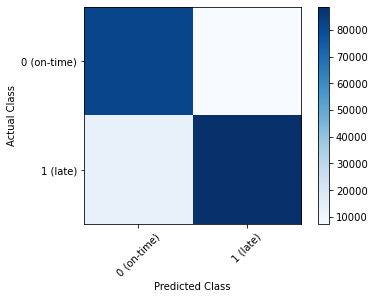

In [35]:
import numpy as np
import matplotlib.pyplot as plt

classes = ['0 (on-time)', '1 (late)']
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

### View the raw prediction and probability

The prediction is based on a raw prediction score that describes a labelled point in a logistic function. This raw prediction is then converted to a predicted label of 0 or 1 based on a probability vector that indicates the confidence for each possible label value (in this case, 0 and 1). The value with the highest confidence is selected as the prediction.

In [37]:
raw_predictions = prediction.select("rawPrediction", "probability", col("prediction").cast("int"), col("Late").alias("trueLabel"))
display(raw_predictions.limit(5))

StatementMeta(sparkezi1n72, 35, 37, Finished, Available)

SynapseWidget(Synapse.DataFrame, 63b0b4bf-8a0c-410c-945e-a53397aea62c)

Note that the results include rows where the probability for 0 (the first value in the **probability** vector) is only slightly higher than the probability for 1 (the second value in the **probability** vector). The default *discrimination threshold* (the boundary that decides whether a probability is predicted as a 1 or a 0) is set to 0.5; so the prediction with the highest probability is always used, no matter how close to the threshold.

### Review the Area Under ROC

Moving the probability threshold above which the model predicts ***1*** would alter the number of true positives and false positives in the confusion matrix. A threshold of zero would predict every case as 1 (positive), while a threshold of 1 would predict every case as 0 (negative). The rate of true-postive and false-postive predictions between these thresholds is a good way to measure the predictive accuracy of a model. An ideal model will show a plotted line that rises vertically up the *true-positive rate* axis and stays at the maximum value (1) across the *false-positive rate*. The *area under the curve* (AUC) can then be calculated as a value between 0 and 1, with a value of 1 indicating a perfect model. In the case of a binary classification model, you can compare this AUC value with 0.5; which would represent the expected prediction rate for a random guess, and which can be plotted as a diagonal line through the ROC curve.

It's generally easier to understand the AUC metric visually by plotting the ROC curve:

StatementMeta(sparkezi1n72, 35, 38, Finished, Available)

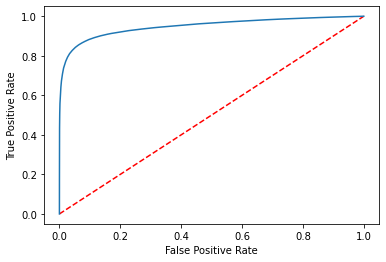

AUC =  0.9482041138494933


In [38]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Plot the ROC curve
modelSummary = model.stages[-1].summary
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Get the AUC
evaluator = BinaryClassificationEvaluator(labelCol="Late", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(prediction)
print ("AUC = ", auc)

## Save and use a model for inferencing

When you're happy with the performance of your model, you can save it. Then, when you need to use it for *inferencing* (predicting) labels for new data, you can load it and transform the new data with it.

In [41]:
from pyspark.ml import PipelineModel

# Save the model
saved_model_path = '/models/flights.model'
model.write().overwrite().save(saved_model_path)

# Load new data for flights in-progress (for which we have no Late" label)
flightSchema = StructType([
  StructField("DayofMonth", IntegerType(), False),
  StructField("DayOfWeek", IntegerType(), False),
  StructField("Carrier", StringType(), False),
  StructField("OriginAirportID", IntegerType(), False),
  StructField("DestAirportID", IntegerType(), False),
  StructField("DepDelay", IntegerType(), False)
])

new_data = spark.read.csv('abfss://data@datalakeezi1n72.dfs.core.windows.net/new-flights.csv', schema=flightSchema, header=True)

# Load the model
loaded_model = PipelineModel.load(saved_model_path)

# Predict labels for the new data
inferences = loaded_model.transform(new_data)

display(inferences)


StatementMeta(sparkezi1n72, 35, 41, Finished, Available)

SynapseWidget(Synapse.DataFrame, fbc68fe3-9893-456f-85af-6aaa70fadc84)

In this notebook, you've explored how to use Spark MLlib to train and use a machine learning model.

We've only scratched the surface of machine learning with MLlib. To learn more, see the [Spark MLlib documentation](https://spark.apache.org/docs/latest/ml-guide.html).